## Homework 02 - Data from the Web

*Remark:* whether you are interested in running all the cells (including the scraping) do that, otherwise, if you want just run the analysis, in the folder `Data_bachelor/` or `Data_master/` you find all the data used in the further analysis. For the tidiness of the notebook the functions used in the script are stored in the file `scraping_function.py`, `analysis_bachelor`.

In [57]:
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import glob
from scraping_function import *
from analysis_bachelor import *

### Assignment 1

The final goal of the task is to verify whether the difference between the number of months that girls took from the first to the sixth semester and the number of months taken by boys, in average, is statistically significant.

Before accomplishing the task we need to pass through the following steps:

1. Obtain all the data for the Bachelor students, starting from 2007.
2. Keep only the students for which you have an entry for both Bachelor semestre 1 and Bachelor semestre 6.
3. Compute how many months it took each student to go from the first to the sixth semester.




#### Step 1

The first thing we do, in order to retrieve the data of interest, is to parse the `html` source related to the `IS-Academia` web page (the one where you have to fill in the form to get the enrolled students). 

In [2]:
# Request the html source for the URL
r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247')
html = r.content
soup = BeautifulSoup(html, 'html.parser')

With the help of *Postman* we identify the *parameters* useful to get the data. They result to be the following:

* `ww_x_GPS`
* `ww_i_reportmodel`
* `ww_i_reportModelXsl`
* `ww_x_UNITE_ACAD`
* `ww_x_PERIODE_ACAD`
* `ww_x_PERIODE_PEDAGO`
* `ww_x_HIVERETE`

We gather them into a dictionary of the following form:

                 {'parameter_1' : {'name_1' : value_1, ..., 'name_n' : value_n},
                  'parameter_2' : {'name_1' : value_1, ..., 'name_n' : value_n},
                   ...........,
                  'parameter_k' : {'name_1' : value_1, ..., 'name_n' : value_n}}
 
Where `parameter_X` is the name the relavant parameter to retrieve, `name_X` and `value_X` are two possible expressions of the parameter (string and numerical respectively). The function to do that is `create_parameter_dict` and it's stored in the [file](Applied data analysis - ADA/scaping_function.py) aforementioned.

In [3]:
# Create the dictionary of parameters
par = ["ww_x_UNITE_ACAD", "ww_x_PERIODE_ACAD", 'ww_x_PERIODE_PEDAGO', 'ww_x_HIVERETE']
dic_par = create_parameter_dict(par, soup)

Thus, we choose and define the procedure to retrieve the information. After analyzing various `URLs`, with the help of *Postman*, we decide that we are going to make in total six requests, each of those consists of asking the list of the students for all the years related to a specific *pedagogic period*. The `URLs` have the following form:
* `ww_x_GPS = -1` : in this way we gather all the data of the page
* `ww_i_reportmodel = 133685247` : standard value of the parameter
* `ww_i_reportModelXsl = dic_par['ww_i_reportModelXsl']['html']` : that specify the form of the data (`html`)
* `ww_x_UNITE_ACAD = dic_par['ww_x_UNITE_ACAD']['Informatique']` : the value that corresponds to the students of Informatique
* `ww_x_PERIODE_PEDAGO: dic_par['ww_x_PERIODE_PEDAGO'][semester]` : the code relative to a specific semester
We don't specify anything about the season and the year beacause we decide to retrive everything related to a particular semester.

In [4]:
# Create the list of the URLs we are making the request to
urls = []

# For each possible semester, 
for semester in dic_par['ww_x_PERIODE_PEDAGO']:
    # Except for those known as semester 5b and 6b that DON'T contain data
    if semester.startswith('Bachelor') and semester[-1] != 'b':  
        # We define the link to append to our list
        url_data = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=' + dic_par['ww_i_reportModelXsl']['html'] + '&ww_x_UNITE_ACAD=' + dic_par['ww_x_UNITE_ACAD']['Informatique'] + '&ww_x_PERIODE_PEDAGO=' + dic_par['ww_x_PERIODE_PEDAGO'][semester]
        urls.append(url_data)

Once the list of links is ready, we proceed retrieving data. To do that we are going to use a function `retrieve_data` which does the following:
- The gathered `html` source code is transformed in a `DataFrame`. 
Since the `html` contains more than one table..
- We are going to split the frame (using the function `fun_rec`) 
Below an image which tries to explain the procedure used to split the big `DataFrame`.

In [5]:
from IPython.display import IFrame
IFrame('disegno_pdf.pdf', width=980, height=500)

- We clean the data using the `clean_df` function, in this step we keep the data of the years of interest 
- And finally save the cleaned `DFs` in `.csv` files (using the `save_data` function)

In [6]:
import os

try:
    os.mkdir('Data_bachelor', 777)
    k = 0
    for ur in urls:
        k += 1
        print ( k, ' request sent.')
        save_data(ur, 'Data_bachelor/')
        print ('Data collected from the ', k, ' request.')
        print ('*****'*10)
    print('Done')
except:
    pass # Data is already fetched

#### Step 2
Now that we have all the data stored, we import and start to analyze them!

We read the `.csv` fies as `DataFrame`, thus we concatenate them on the axis 0. It's done by the `import_data` function.

In [7]:
data = import_data('Data_bachelor/')

Hence, we proceed accomplishing the task of this step, in fact we filter the df according to the required criteria. In particulare we `groupby` the frame according to the *Sciper number* that is unique for each enrolled student. Then we keep only the students (group) that have in the domain *Pedagogic period* at least one *Semester 1 & Semester 6*. A more technical procedure is explained inside the function `extract_students`.

In [8]:
df_students = extract_students(data)

In [9]:
df_students.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No_Sciper,Academic year,Pedagogic period
0,Monsieur,Arévalo Christian,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,169569,2007-2008,Bachelor semestre 1
1,Monsieur,Aubelle Flavien,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,174905,2007-2008,Bachelor semestre 1
3,Monsieur,Baeriswyl Jonathan,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,179406,2007-2008,Bachelor semestre 1
4,Monsieur,Barroco Michael,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,179428,2007-2008,Bachelor semestre 1
7,Monsieur,Bindschaedler Vincent,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,179449,2007-2008,Bachelor semestre 1


#### Step 3

In this step we compute how many months each student spent to get from the 1st to the 6th semester. The assumptions we rely on are the following:
- A student reach the *Semester 6* whether he doesn't have to sit again any other semester. We make this assumption because we think that the choice of the 6th semester is useful to compute the time an epfl student need to graduated at bachelor
- Each semester lasts 6 months

Before getting the duration of studies for each student, since we want to get their names, we check whether the name could be considered as an index. The way we do that is that the number of *names* should be equal to the number of *Scipers*.

In [17]:
len(df_students['Nom Prénom'].unique()) == len(df_students['No_Sciper'].unique())

True

Thus, we `groupby` the *name* of the student and then we get the number of rows (`size`) of the group. It corresponds exactly to months needed by the student to reach the 6th semester.

In [32]:
df_grouped = df_students.groupby(['Civilité' , 'Nom Prénom'])

The number of semester which the student resulted to have been enrolled is multiplied by 6 that is the duration of a semester according to our assumption.

In [40]:
df_male_aggregated = pd.DataFrame(df_students[df_students['Civilité'] == 'Monsieur'].groupby('Nom Prénom').size()*6)

In [54]:
df_male_aggregated.describe()

,0
count,368.000000
mean,42.635870
std,9.221348
min,24.000000
25%,36.000000
50%,36.000000
75%,48.000000
max,72.000000


(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  203.,    0.,    0.,    0.,    0.,    0.,
          38.,    0.,    0.,    0.,    0.,    0.,    0.,   67.,    0.,
           0.,    0.,    0.,    0.,   21.,    0.,    0.,    0.,    0.,
           0.,   22.,    0.,    0.,    0.,    0.,    0.,   10.,    0.,
           0.,    0.,    0.,    0.,    6.]),
 array([ 24.  ,  24.96,  25.92,  26.88,  27.84,  28.8 ,  29.76,  30.72,
         31.68,  32.64,  33.6 ,  34.56,  35.52,  36.48,  37.44,  38.4 ,
         39.36,  40.32,  41.28,  42.24,  43.2 ,  44.16,  45.12,  46.08,
         47.04,  48.  ,  48.96,  49.92,  50.88,  51.84,  52.8 ,  53.76,
         54.72,  55.68,  56.64,  57.6 ,  58.56,  59.52,  60.48,  61.44,
         62.4 ,  63.36,  64.32,  65.28,  66.24,  67.2 ,  68.16,  69.12,
         70.08,  71.04,  72.  ]),
 <a list of 50 Patch objects>)

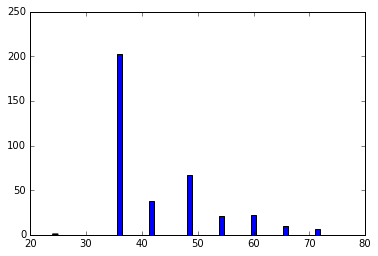

In [49]:
plt.hist(df_male_aggregated.values, bins = 50)

In [56]:
df_male_aggregated[df_male_aggregated[0] <= 65].describe()

,0
count,352.000000
mean,41.471591
std,7.566931
min,24.000000
25%,36.000000
50%,36.000000
75%,48.000000
max,60.000000


In [42]:
df_female_aggregated = pd.DataFrame(df_students[df_students['Civilité'] == 'Madame'].groupby('Nom Prénom').size()*6)

In [44]:
df_female_aggregated.describe()

,0
count,29.000000
mean,40.758621
std,8.078433
min,36.000000
25%,36.000000
50%,36.000000
75%,48.000000
max,66.000000


(array([ 20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 36. ,  36.6,  37.2,  37.8,  38.4,  39. ,  39.6,  40.2,  40.8,
         41.4,  42. ,  42.6,  43.2,  43.8,  44.4,  45. ,  45.6,  46.2,
         46.8,  47.4,  48. ,  48.6,  49.2,  49.8,  50.4,  51. ,  51.6,
         52.2,  52.8,  53.4,  54. ,  54.6,  55.2,  55.8,  56.4,  57. ,
         57.6,  58.2,  58.8,  59.4,  60. ,  60.6,  61.2,  61.8,  62.4,
         63. ,  63.6,  64.2,  64.8,  65.4,  66. ]),
 <a list of 50 Patch objects>)

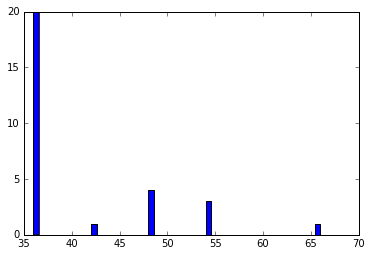

In [51]:
plt.hist(df_female_aggregated.values, bins = 50)

In [58]:
stats.ttest_ind(df_male_aggregated, df_female_aggregated, equal_var=False)

Ttest_indResult(statistic=array([ 1.1917057]), pvalue=array([ 0.24162457]))